# JWST Pipeline Validation Testing Notebook: MIRI LRS Slitless spectroscopy

# Step: flat_field() in Spec2Pipeline

**Instruments Affected**: MIRI

# Table of Contents

 - Imports
 - Introduction
 - Run Pipeline
 - Flat Field Step Check

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
data_dir = TemporaryDirectory()
os.chdir(data_dir.name)

# Imports

 - os for simple operating system functions
 - gwcs.wcstools for bounding box operations
 - astropy.io for opening fits files
 - inspect to get the docstring of our objects.
 - IPython.display for printing markdown output
 - jwst.datamodels for building model for JWST Pipeline
 - jwst.module.PipelineStep is the pipeline step being tested
 - matplotlib.pyplot to generate plot
 - matplotlib.patches to plot shapes
 - crds for retrieving a reference file
 - astropy.utils for Box access to data
 - glob for file searching operations
 - ci_watson for artifactory data retrieval

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
import statistics as stat
import numpy as np
from jwst.pipeline import Detector1Pipeline, Spec2Pipeline, collect_pipeline_cfgs
from jwst.pipeline import Spec2Pipeline
from jwst.background import BackgroundStep
from jwst.assign_wcs import AssignWcsStep
from jwst.extract_2d import Extract2dStep
from jwst.flatfield import FlatFieldStep
from astropy.utils.data import download_file
from jwst.datamodels import ImageModel, CubeModel
import crds
import os
import glob
from jwst import datamodels
from ci_watson.artifactory_helpers import get_bigdata

# Introduction
For this test we are using the flat fielding step for MIRI LRS slitless (TSO) data. For more information on the pipeline step visit the links below.
  
Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/flatfield/main.html#imaging-and-non-nirspec-spectroscopic-data
  
Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/flat_field
  
## Defining Terms

 - JWST: James Webb Space Telescope 
 - MIRI: Mid-Infrared Instrument 
 - LRS: Low Resolution Spectrometer

## Retrieving data

The simulated data are stored in Box and can be retrieved from there programmatically. The simulated data were generated with MIRISim v2.3.0. The observation consists of an observation of a stellar source in the slitless view. In this scenario, one exposures is executed at the center of the field of view.

In [3]:
exp_file = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_tso3',
                                    'tso3_miri_test',
                                    'pipetest_miri_lrs_tso_100G10I.fits')

sci_mod = datamodels.open(exp_file)
print(sci_mod)

<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>


# Run Pipeline

We are using here a simulated TSO observation, generated with MIRISim v.2.3. It is a single exposure of a star with 100 groups per integration and 10 integrations. LRS TSOs uses the SLITLESSPRISM subarray, so the data do not cover the full array.

The data are stored on artifactory and we will retrieve from there.

[Top of Page](#title_ID)

In [4]:
#if not os.path.exists('../cfg_files/'):
#    os.mkdir('../cfg_files/')
#    cfgs = collect_pipeline_cfgs.collect_pipeline_cfgs(dst='../cfg_files/')

In [5]:
det1 = Detector1Pipeline.call(sci_mod, save_results=True)

2021-10-05 05:30:14,847 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0002.asdf


2021-10-05 05:30:14,869 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-10-05 05:30:14,871 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-10-05 05:30:14,872 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-10-05 05:30:14,873 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-10-05 05:30:14,875 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-10-05 05:30:14,876 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-10-05 05:30:14,877 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-10-05 05:30:14,878 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-10-05 05:30:14,880 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-10-05 05:30:14,881 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-10-05 05:30:14,882 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-10-05 05:30:14,883 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-10-05 05:30:14,884 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-10-05 05:30:14,886 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-10-05 05:30:14,887 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-10-05 05:30:14,888 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-10-05 05:30:14,890 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-10-05 05:30:15,007 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-10-05 05:30:15,017 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': True, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output

2021-10-05 05:30:15,026 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'pipetest_miri_lrs_tso_100G10I.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'saturation', 'superbias']


2021-10-05 05:30:15,037 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0048.fits'.


2021-10-05 05:30:15,039 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2021-10-05 05:30:15,041 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2021-10-05 05:30:15,043 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2021-10-05 05:30:15,045 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0070.fits'.


2021-10-05 05:30:15,047 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2021-10-05 05:30:15,048 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0043.fits'.


2021-10-05 05:30:15,049 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2021-10-05 05:30:15,051 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-10-05 05:30:15,053 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-10-05 05:30:15,230 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-10-05 05:30:15,232 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-05 05:30:15,495 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-10-05 05:30:15,497 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-10-05 05:30:15,499 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-10-05 05:30:15,678 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-10-05 05:30:15,680 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-05 05:30:15,701 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2021-10-05 05:30:16,082 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2021-10-05 05:30:16,093 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-10-05 05:30:16,323 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-10-05 05:30:16,326 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-05 05:30:16,347 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2021-10-05 05:30:16,620 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2021-10-05 05:30:16,888 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2021-10-05 05:30:16,902 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-10-05 05:30:16,906 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-10-05 05:30:17,129 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-10-05 05:30:17,132 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-05 05:30:17,133 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-10-05 05:30:17,135 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-10-05 05:30:17,315 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-10-05 05:30:17,318 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-05 05:30:17,319 - stpipe.Detector1Pipeline.firstframe - INFO - Step skipped.


2021-10-05 05:30:17,321 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-10-05 05:30:17,501 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-10-05 05:30:17,503 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-05 05:30:17,504 - stpipe.Detector1Pipeline.lastframe - INFO - Step skipped.


2021-10-05 05:30:17,506 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-10-05 05:30:17,682 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-10-05 05:30:17,684 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-05 05:30:17,708 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0043.fits


2021-10-05 05:30:17,738 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESET_LARGE does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-05 05:30:18,013 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-10-05 05:30:18,244 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-10-05 05:30:18,247 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-05 05:30:18,268 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2021-10-05 05:30:18,613 - stpipe.Detector1Pipeline.linearity - INFO - Extracting linearity subarray to match science data


2021-10-05 05:30:18,923 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-10-05 05:30:19,131 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-10-05 05:30:19,133 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-10-05 05:30:19,134 - stpipe.Detector1Pipeline.rscd - INFO - Step skipped.


2021-10-05 05:30:19,135 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-10-05 05:30:19,330 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-10-05 05:30:19,332 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-10-05 05:30:19,355 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0048.fits


2021-10-05 05:30:19,646 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=10, ngroups=100, nframes=1, groupgap=0


2021-10-05 05:30:19,647 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=1000, nframes=1, groupgap=0


2021-10-05 05:30:20,050 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-10-05 05:30:20,295 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-10-05 05:30:20,297 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-10-05 05:30:20,308 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2021-10-05 05:30:20,309 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2021-10-05 05:30:20,310 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2021-10-05 05:30:20,310 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000


2021-10-05 05:30:20,311 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2021-10-05 05:30:20,530 - stpipe.Detector1Pipeline.refpix - WARNING - Refpix correction skipped for MIRI subarrays


2021-10-05 05:30:20,534 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-10-05 05:30:20,734 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-10-05 05:30:20,737 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-10-05 05:30:20,747 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-10-05 05:30:20,761 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-10-05 05:30:20,799 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0070.fits


2021-10-05 05:30:20,816 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-10-05 05:30:20,990 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2021-10-05 05:30:21,096 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-10-05 05:30:21,360 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-10-05 05:30:21,512 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 4166 pixels with at least one CR and at least four groups


2021-10-05 05:30:21,514 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-05 05:30:21,515 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2021-10-05 05:30:21,722 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-10-05 05:30:21,875 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 4287 pixels with at least one CR and at least four groups


2021-10-05 05:30:21,876 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-05 05:30:21,877 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2021-10-05 05:30:22,119 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-10-05 05:30:22,250 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 4333 pixels with at least one CR and at least four groups


2021-10-05 05:30:22,251 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-05 05:30:22,252 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2021-10-05 05:30:22,473 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2021-10-05 05:30:22,596 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 4248 pixels with at least one CR and at least four groups


2021-10-05 05:30:22,597 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-05 05:30:22,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2021-10-05 05:30:22,830 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 5:


2021-10-05 05:30:22,953 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 4267 pixels with at least one CR and at least four groups


2021-10-05 05:30:22,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-05 05:30:22,955 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2021-10-05 05:30:23,174 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 6:


2021-10-05 05:30:23,301 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 4309 pixels with at least one CR and at least four groups


2021-10-05 05:30:23,302 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-05 05:30:23,303 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2021-10-05 05:30:23,522 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 7:


2021-10-05 05:30:23,661 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 4266 pixels with at least one CR and at least four groups


2021-10-05 05:30:23,662 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-05 05:30:23,663 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2021-10-05 05:30:23,864 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 8:


2021-10-05 05:30:23,988 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 4286 pixels with at least one CR and at least four groups


2021-10-05 05:30:23,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-05 05:30:23,990 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2021-10-05 05:30:24,214 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 9:


2021-10-05 05:30:24,337 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 4270 pixels with at least one CR and at least four groups


2021-10-05 05:30:24,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-05 05:30:24,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2021-10-05 05:30:24,563 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 10:


2021-10-05 05:30:24,688 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 4285 pixels with at least one CR and at least four groups


2021-10-05 05:30:24,689 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-05 05:30:24,690 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2021-10-05 05:30:24,924 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 3.82688 sec


2021-10-05 05:30:24,929 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 4.181466


2021-10-05 05:30:24,933 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-10-05 05:30:25,183 - stpipe.Detector1Pipeline - INFO - Saved model in pipetest_miri_lrs_tso_100G10I_ramp.fits


2021-10-05 05:30:25,417 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I_ramp.fits>,).


2021-10-05 05:30:25,419 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-10-05 05:30:25,449 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0070.fits


2021-10-05 05:30:25,465 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-10-05 05:30:25,482 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-10-05 05:30:25,483 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-10-05 05:30:25,484 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2021-10-05 05:30:25,487 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 0


2021-10-05 05:31:38,781 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 100


2021-10-05 05:31:38,784 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 10


2021-10-05 05:31:38,876 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-10-05 05:31:39,112 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(416, 72) from pipetest_miri_lrs_tso_100G10I_ramp.fits>,).


2021-10-05 05:31:39,114 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-10-05 05:31:39,154 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-05 05:31:39,155 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-05 05:31:39,158 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-05 05:31:39,250 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(10, 416, 72) from pipetest_miri_lrs_tso_100G10I_ramp.fits>,).


2021-10-05 05:31:39,253 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-10-05 05:31:39,285 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-05 05:31:39,286 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-05 05:31:39,289 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-05 05:31:39,347 - stpipe.Detector1Pipeline - INFO - Saved model in pipetest_miri_lrs_tso_100G10I_rateints.fits


2021-10-05 05:31:39,350 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-10-05 05:31:39,394 - stpipe.Detector1Pipeline - INFO - Saved model in pipetest_miri_lrs_tso_100G10I_rate.fits


2021-10-05 05:31:39,395 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


The ``det1`` output corresponds to the \_rate.fits file, which has the integrations co-added. For time series observations, we proceed with the \_rateints.fits file, in which integrations are not co-added. So we find that file and load it in for further processing.

In [6]:
rifile = glob.glob('*_rateints.fits')
print(rifile)

det1_ints = datamodels.open(rifile[0])

['pipetest_miri_lrs_tso_100G10I_rateints.fits']


Now we run the assign_wcs(), extract2d() steps with this model. 

In [7]:
awcs = AssignWcsStep.call(det1_ints, save_results=True)

2021-10-05 05:31:39,471 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2021-10-05 05:31:39,561 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<CubeModel(10, 416, 72) from pipetest_miri_lrs_tso_100G10I_rateints.fits>,).


2021-10-05 05:31:39,563 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-05 05:31:39,856 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_lrs-slitless pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0003.fits', 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-10-05 05:31:39,921 - stpipe.AssignWcsStep - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-10-05 05:31:39,928 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  0.000981120 -0.000094311 0.000981120 0.000098852 359.998963682 0.000098852 359.998963682 -0.000094311


2021-10-05 05:31:39,929 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.000981120 -0.000094311 0.000981120 0.000098852 359.998963682 0.000098852 359.998963682 -0.000094311


2021-10-05 05:31:39,929 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2021-10-05 05:31:40,057 - stpipe.AssignWcsStep - INFO - Saved model in pipetest_miri_lrs_tso_100G10I_assignwcsstep.fits


2021-10-05 05:31:40,059 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


In [8]:
ff = FlatFieldStep.call(awcs,save_results='True')

2021-10-05 05:31:40,077 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.


2021-10-05 05:31:40,173 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args (<CubeModel(10, 416, 72) from pipetest_miri_lrs_tso_100G10I_assignwcsstep.fits>,).


2021-10-05 05:31:40,175 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-10-05 05:31:40,244 - stpipe.FlatFieldStep - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-05 05:31:40,245 - stpipe.FlatFieldStep - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-05 05:31:40,246 - stpipe.FlatFieldStep - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-05 05:31:40,248 - stpipe.FlatFieldStep - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-05 05:31:40,466 - stpipe.FlatFieldStep - INFO - Saved model in pipetest_miri_lrs_tso_100G10I_flatfieldstep.fits


2021-10-05 05:31:40,467 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep done


# Flat Field Step Check
Now that we have the output from the flat fielding step, we will download the reference file from crds and perform an independent check that the step is correctly executed.

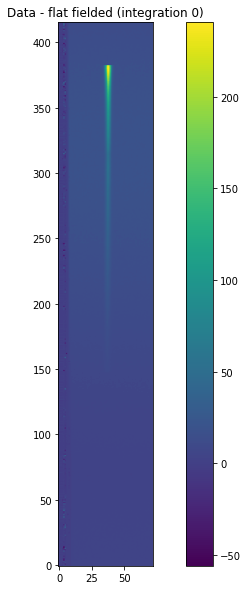

In [9]:
fig = plt.figure(figsize=[12,10])
plt.imshow(ff.data[0,:,:], origin='lower')
plt.title('Data - flat fielded (integration 0)')
plt.colorbar()

In [10]:
flat_reffile = ff.meta.ref_file.flat.name
basename = crds.core.config.pop_crds_uri(flat_reffile)
filepath = crds.locate_file(basename, "jwst")
reffile =  datamodels.open(filepath)

2021-10-05 05:31:40,682 - stpipe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-05 05:31:40,683 - stpipe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-05 05:31:40,684 - stpipe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-05 05:31:40,686 - stpipe - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


In [11]:
manflat = awcs.data / reffile.data

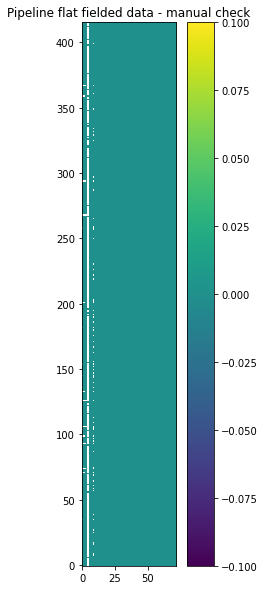

In [12]:
fig = plt.figure(figsize=[4,10])
fcheck = (ff.data - manflat)
plt.imshow(fcheck[0,:,:], origin='lower', interpolation='None')
plt.title('Pipeline flat fielded data - manual check')
plt.colorbar()
fig.show()

In [13]:
nans = np.isnan(fcheck)
print('Min difference between manual & pipeline files, nod 1 = {0} -- Max = {1}'.format(np.min(fcheck[~nans]), np.max(fcheck[~nans])))

# perform a numeric check. Ignoring NaNs for now as these do not fully match:
assert np.allclose(ff.data[~nans], manflat[~nans], equal_nan=True), "Pipeline calibrated file doesn't match the manual check to within tolerances"

Min difference between manual & pipeline files, nod 1 = 0.0 -- Max = 0.0


If all assert statements in this notebook PASS, then the test is successful.
  
## END
  
* Authors: K. Murray (kmurray@stsci.edu), S. Kendrew (sarah.kendrew@esa.int) -- MIRI branch
* Last updated: 12/14/2020